<a href="https://colab.research.google.com/gist/fernandoferreira-me/61e9e4a25060f95abbfdb8cb90aaaed9/question-rio-projeto-de-disciplina-de-text-mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Disciplina de Processamento de Linguagem Natural com Python

Bem-vindo ao projeto de disciplina de **Processamento de Linguagem Natural com Python**. Ao longo das últimas aulas vimos uma série de aplicações que nos deram a amplitude de possibilidades em trabalhar com textos. Para tal, usamos diversas bibliotecas, onde as que mais se destacaram foram NLTK, SPACY e GENSIM.

Esse notebook servirá de guia para a execução de uma análise de tópicos completa, usando o algoritmo de LDA e recursos para interpretação dos resultados. Utilizaremos notícias da seção "Mercado" extraídas da Folha de S. Paulo no ano de 2016.  Complete a análise com os códigos que achar pertinente e responda as questões presentes no Moodle. Boa sorte!

## O Notebook

Nesse notebook, você será guiado pela análise de **Extração de Tópicos**. As seguintes tarefas serão realizadas


1.   Download dos dados provenientes do kaggle 
2.   Seleção dos dados relevantes para a nossa análise
3.   Instalação das principais ferramentas e importação de módulos
4.   Pré-processamento usando NLTK
5.   Pré-processamento usando Spacy
6.   Análise de tópicos usando LDA
7.   Análise de NER usando Spacy
8.   Visualização dos tópicos usando tokens e entidades.



## Instruções para baixar os dados

Para baixar os dados será necessário o uso do gerenciador de downloads da Kaggle. A Kaggle, uma subsidiária do grupo Alphabet (Google), é uma comunidade on-line de cientistas de dados e profissionais de aprendizado de máquina.

Para utilizar o gerenciador, será necessário criar uma conta no site Kaggle.com.
Com a conta criada, obtenha um token de acesso, no formato kaggle.json

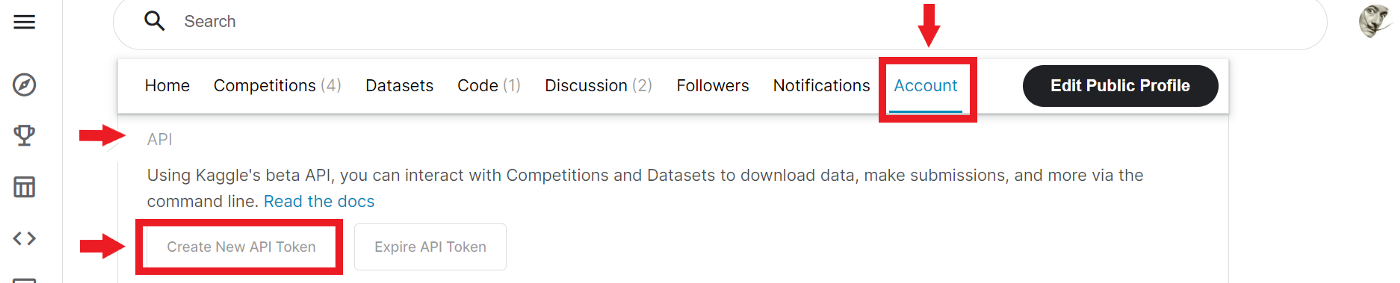

Em posse do token (baixe para seu computador), execute a células da próxima seção para acessar os dados de interesse e baixá-los.

# Baixe os dados

Instale o gerenciador kaggle no ambiente do Colab e faça o upload do arquivo kaggle.json

### 1 - Qual o endereço do seu notebook (colab) executado? Use o botão de compartilhamento do colab para obter uma url.

https://github.com/lucasmaiamoreira/NLP-Text-Analysis.git

### Todas as bibliotecas usadas estão dentro do arquivo requirements.txt

#### Será necessário realizar a instalação usando o comando abaixo:

pip install -r requirements.txt

In [1]:
# !pip install -q kaggle
# !rm -rf kaggle.json
# # from google.colab import files

# # files.upload()

Crie a pasta .kaggle

In [2]:
# !rm -rf .kaggle
# !mkdir .kaggle
# !cp kaggle.json .kaggle/
# !chmod 600 .kaggle/kaggle.json

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer

from typing import List, Set, Any

import pandas as pd
from tqdm import tqdm

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
from scipy.sparse import csr_matrix
from spacy.lang.pt import Portuguese


from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

import pyLDAvis
import pyLDAvis.lda_model

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

from sklearn.decomposition import LatentDirichletAllocation

import warnings

warnings.filterwarnings('ignore')

SEED = 123

# Atualizar o SPACY e  instalar os modelos pt_core_news_lg

### Célula que está o código que atualiza o spacy e instala o pacote pt_core_news_lg.

In [4]:
!python -m spacy download pt_core_news_lg
!pip install -U spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 5.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


### Download dos dados diretamente do kaggle:

In [5]:
!kaggle datasets download --force -d marlesson/news-of-the-site-folhauol

Dataset URL: https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol
License(s): CC0-1.0
 99%|███████████████████████████████████████▋| 186M/187M [00:06<00:00, 31.9MB/s]
100%|████████████████████████████████████████| 187M/187M [00:06<00:00, 28.3MB/s]


### Criação do dataframe news_2016 (com examente 7943 notícias):

In [6]:
tqdm.pandas()
df = pd.read_csv("news-of-the-site-folhauol.zip")

### Modelo pt_core_news_lg sendo carregado, Todos os textos do dataframe precisam ser analisados usando os modelos carregados.

In [7]:
nlp = spacy.load("pt_core_news_lg")

print(list(STOP_WORDS)[:10])

['acerca', 'as', 'algo', 'fará', 'cujo', 'fazemos', 'quinta', 'parte', 'porém', 'às']


## Instalar os datasets `stopwords`, `punkt` e `rslp` do nltk

### Download dos pacotes necessários para tokenização e stemming usando nltk:

In [8]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /home/lucas-
[nltk_data]     pessoal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/lucas-
[nltk_data]     pessoal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /home/lucas-
[nltk_data]     pessoal/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

## Carregar os módulos usados ao longo desse notebook

In [9]:
# !pip install pyldavis
# !pip install wordcloud
# !pip install seaborn

# Filtrando os dados para utilizar apenas as notícias do ano de 2016 e da categoria "Mercado"

Filtre os dados do DataFrame df e crie um DataFrame news_2016 que contenha apenas notícias de **2016** e da categoria **mercado**.

In [10]:
df['date'] = pd.to_datetime(df.date)

news_2016 = df[(df['date'].dt.year == 2016) & (df['category'] == 'mercado')].copy()

display(news_2016.head())

,title,text,date,category,subcategory,link
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...


## NLTK Tokenizer and Stemmer

Crie uma coluna no dataframe `news_2016` contendo os tokens para cada um dos textos. Os tokens devem estar representados pelo radical das palavras (stem). 
Para tal, complete o conteúdo da função `tokenize`.

### Função que tokeniza e realiza o stemming dos textos usando funções do nltk:

In [11]:
def tokenize(text: str) -> List[str]:
    """
    Função para tokenizar usando `nltk.tokenize.word_tokenize`
    
    Retorna:
        - Uma lista de tokens radicalizados (`nltk.stem.RSLPStemmer`)
        IMPORTANTE: Somente tokens com caracteres alfabéticos serão retornados.
    """
    stemmer = RSLPStemmer()

    tokens = word_tokenize(text, language='portuguese')
    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token.isalpha()]
    return stemmed_tokens

news_2016.loc[:, 'nltk_tokens'] = news_2016.text.progress_map(tokenize)

display(news_2016.head())

100%|██████████| 7943/7943 [01:33<00:00, 84.76it/s] 


,title,text,date,category,subcategory,link,nltk_tokens
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri..."
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, ou, control, fic, mais, c..."
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont..."
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,..."
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d..."


## Criar uma documento SPACY para cada texto do dataset

Crie uma coluna `spacy_doc` que contenha os objetos spacy para cada texto do dataset de interesse. Para tal, carregue os modelos `pt_core_news_lg` e aplique em todos os textos (pode demorar alguns minutos...)

In [12]:
def process_text(text: str) -> spacy.tokens.Doc:
    """
    Função para processar o texto usando o modelo do Spacy
    
    Retorna:
        - Objeto do documento Spacy
    """
    doc = nlp(text)
    return doc

news_2016['spacy_doc'] = news_2016['text'].progress_map(process_text)

display(news_2016.head())

100%|██████████| 7943/7943 [06:19<00:00, 20.91it/s]


,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri...","("", Sou, apenas, a, mulher, de, um, fazendeiro..."
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, ou, control, fic, mais, c...","(A, conta, do, celular, pós-pago, ou, controle..."
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont...","(A, maior, parte, dos, projetos, de, ajuste, d..."
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,...","(Desde, as, primeiras, décadas, do, século, 19..."
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d...","(O, Cifras, &, Letras, seleciona, semanalmente..."


## Realize a Lematização usando SPACY

O modelo NLP do spacy oferece a possiblidade de lematizar textos em português (o que não acontece com a biblioteca NLTK). Iremos criar uma lista de tokens
lematizados para cada texto do nosso dataset. Para tal, iremos retirar as 
stopwords, usando uma função que junta stopwords provenientes do NLTK e do Spacy. Essa lista completa, é retornada pela função stopwords (e você não precisa mexer).

Já a função filter retorna True caso o token seja composto por caracters alfabéticos, não estiver dentro da lista de stopwords e o lemma resultante não estiver contido na lista `o", "em", "em o", "em a" e "ano"`.

Crie uma coluna chamada `spacy_lemma` para armazenar o resultado desse pré-processamento.

### Função que realiza a lematização usando o spacy:

In [13]:
def stopwords() -> Set[str]:
    """
    Retorna uma lista completa de stopwords
    """
    return set(list(nltk.corpus.stopwords.words("portuguese")) + list(STOP_WORDS))

complete_stopwords = stopwords()

def filter(w: spacy.tokens.Token) -> bool:
    """
    Filtrar stopwords e tokens indesejados
    """
    return not (w.is_stop or not w.is_alpha or w.lemma_ in complete_stopwords 
                or w.lemma_ in ["o", "em", "em o", "em a", "ano"])

def lemma(doc: spacy.tokens.Doc) -> List[str]:
    """
    Aplicar lematização do Spacy nos tokens de um texto
    
    Retorna:
        - uma lista representando o vocabulário padronizado (com lematização)
    """
    return [token.lemma_ for token in doc if filter(token)]

news_2016['spacy_lemma'] = news_2016['spacy_doc'].progress_map(lemma)

display(news_2016.head())

  0%|          | 0/7943 [00:00<?, ?it/s]

100%|██████████| 7943/7943 [00:02<00:00, 3845.29it/s]


,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc,spacy_lemma
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri...","("", Sou, apenas, a, mulher, de, um, fazendeiro...","[mulher, fazendeiro, Christine, Conder, modést..."
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, ou, control, fic, mais, c...","(A, conta, do, celular, pós-pago, ou, controle...","[conta, celular, controle, ficar, cara, decisã..."
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont...","(A, maior, parte, dos, projetos, de, ajuste, d...","[projeto, ajuste, conta, público, aprovar, mau..."
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,...","(Desde, as, primeiras, décadas, do, século, 19...","[década, século, nota, ópera, sinfonia, brotar..."
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d...","(O, Cifras, &, Letras, seleciona, semanalmente...","[Cifras, Letras, selecionar, semanalmente, lan..."


## Reconhecimento de entidades nomeadas

Crie uma coluna `spacy_ner` que armazene todas as organizações (APENAS organizações) que estão contidas no texto.

### Entidades dos textos foram extraídas. Estamos interessados apenas nas organizações.

In [14]:
def NER(doc: spacy.tokens.Doc):
    """
    Retorna a lista de organizações para um documento SPACY
    """
    organizations = [entity.text for entity in doc.ents if entity.label_ == 'ORG']
    return organizations

news_2016['spacy_ner'] = news_2016['spacy_doc'].progress_map(NER)

display(news_2016.head())


100%|██████████| 7943/7943 [00:00<00:00, 23371.98it/s]


,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc,spacy_lemma,spacy_ner
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri...","("", Sou, apenas, a, mulher, de, um, fazendeiro...","[mulher, fazendeiro, Christine, Conder, modést...","[Ofcom, Cavamos, LEMA, Membro, Ordem do Impéri..."
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, ou, control, fic, mais, c...","(A, conta, do, celular, pós-pago, ou, controle...","[conta, celular, controle, ficar, cara, decisã...","[Oi, TIM, Claro, Vivo, GERCINA, FERNANDA BRIGA..."
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont...","(A, maior, parte, dos, projetos, de, ajuste, d...","[projeto, ajuste, conta, público, aprovar, mau...","[Executivo dos três Estados, Assembleias locai..."
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,...","(Desde, as, primeiras, décadas, do, século, 19...","[década, século, nota, ópera, sinfonia, brotar...","[MIT, Instituto de Tecnologia de Massachusetts..."
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d...","(O, Cifras, &, Letras, seleciona, semanalmente...","[Cifras, Letras, selecionar, semanalmente, lan...","[NACIONAIS , Presidente da Singularity Univer..."


## Bag-of-Words

Crie uma coluna `tfidf` no dataframe `news_2016`. Use a coluna `spacy_lemma` como base para cálculo do TFIDF. 
O número máximo de features que iremos considerar é 5000. E o token, tem que ter aparecido pelo menos 10 vezes (`min_df`) nos documentos. 

In [15]:
class Vectorizer:
    def __init__(self, doc_tokens: List[List[str]], max_features: int = 5000, min_df: int = 10):
        self.doc_tokens = doc_tokens
        self.max_features = max_features
        self.min_df = min_df
        self.tfidf_vectorizer = None

    def vectorizer(self):
        """
        Converte uma lista de tokens em um vetor TFIDF
        Retorna o vetor TFIDF e atribui-o a self.tfidf_vectorizer
        """
        
        self.tfidf_vectorizer = TfidfVectorizer(max_features=self.max_features, min_df=self.min_df)
        
        self.tfidf_vectorizer.fit([" ".join(tokens) for tokens in self.doc_tokens])
        
    def __call__(self):
        if self.tfidf_vectorizer is None:
            self.vectorizer()
        return self.tfidf_vectorizer

doc_tokens = news_2016['spacy_lemma'].tolist()

vectorizer = Vectorizer(doc_tokens)

### Função que cria o vetor de TF-IDF para cada texto:

In [16]:
def tokens2tfidf(tokens):
    vectorizer_instance = vectorizer()
    array = vectorizer_instance.transform([" ".join(tokens)]).toarray()[0]
    return array

news_2016['tfidf'] = news_2016['spacy_lemma'].progress_map(tokens2tfidf)

display(news_2016.head())

100%|██████████| 7943/7943 [00:06<00:00, 1249.52it/s]


,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc,spacy_lemma,spacy_ner,tfidf
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri...","("", Sou, apenas, a, mulher, de, um, fazendeiro...","[mulher, fazendeiro, Christine, Conder, modést...","[Ofcom, Cavamos, LEMA, Membro, Ordem do Impéri...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, ou, control, fic, mais, c...","(A, conta, do, celular, pós-pago, ou, controle...","[conta, celular, controle, ficar, cara, decisã...","[Oi, TIM, Claro, Vivo, GERCINA, FERNANDA BRIGA...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont...","(A, maior, parte, dos, projetos, de, ajuste, d...","[projeto, ajuste, conta, público, aprovar, mau...","[Executivo dos três Estados, Assembleias locai...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,...","(Desde, as, primeiras, décadas, do, século, 19...","[década, século, nota, ópera, sinfonia, brotar...","[MIT, Instituto de Tecnologia de Massachusetts...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d...","(O, Cifras, &, Letras, seleciona, semanalmente...","[Cifras, Letras, selecionar, semanalmente, lan...","[NACIONAIS , Presidente da Singularity Univer...","[0.0, 0.04241729933086497, 0.0, 0.0, 0.0, 0.0,..."


## Extração de Tópicos

Realize a extração de 9 tópicos usando a implementação do sklearn do algoritmo Latent Dirichlet Allocation. Como parâmetros, você irá usar o número máximo de iterações igual à 100 (pode demorar) e o `random_seed` igual a `SEED` que foi setado no início do notebook

### Extraindo tópicos usando o algoritmo de LDA.

In [17]:
N_TOKENS = 9

corpus = np.array(news_2016['tfidf'].tolist())
lda = LatentDirichletAllocation(n_components=N_TOKENS, max_iter=100, random_state=SEED)
lda.fit(corpus)

LatentDirichletAllocation(max_iter=100, n_components=9, random_state=123)

### Visualize os tópicos usando a ferramenta pyLDAVis

### Visualização LDAVis criada:

In [18]:
corpus_sparse = csr_matrix(corpus)

pyLDAvis.enable_notebook()
vis_data = pyLDAvis.lda_model.prepare(lda, corpus_sparse, vectorizer())

pyLDAvis.display(vis_data)

### Atribua a cada text, um (e apenas um) tópic. 

Crie uma coluna `topic` onde o valor é exatamente o tópico que melhor caracteriza o documento de acordo com o algoritmo de LDA.

In [19]:
def get_topic(tfidf: np.array):
    """
    Obtém o tópico para um modelo LDA treinado
    """
    topic_distribution = lda.transform(tfidf.reshape(1, -1))
    
    dominant_topic_index = np.argmax(topic_distribution)
    return dominant_topic_index

news_2016['topic'] = news_2016['tfidf'].progress_map(get_topic)
display(news_2016.head())

100%|██████████| 7943/7943 [00:03<00:00, 2250.97it/s]


,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc,spacy_lemma,spacy_ner,tfidf,topic
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri...","("", Sou, apenas, a, mulher, de, um, fazendeiro...","[mulher, fazendeiro, Christine, Conder, modést...","[Ofcom, Cavamos, LEMA, Membro, Ordem do Impéri...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, ou, control, fic, mais, c...","(A, conta, do, celular, pós-pago, ou, controle...","[conta, celular, controle, ficar, cara, decisã...","[Oi, TIM, Claro, Vivo, GERCINA, FERNANDA BRIGA...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont...","(A, maior, parte, dos, projetos, de, ajuste, d...","[projeto, ajuste, conta, público, aprovar, mau...","[Executivo dos três Estados, Assembleias locai...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,...","(Desde, as, primeiras, décadas, do, século, 19...","[década, século, nota, ópera, sinfonia, brotar...","[MIT, Instituto de Tecnologia de Massachusetts...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d...","(O, Cifras, &, Letras, seleciona, semanalmente...","[Cifras, Letras, selecionar, semanalmente, lan...","[NACIONAIS , Presidente da Singularity Univer...","[0.0, 0.04241729933086497, 0.0, 0.0, 0.0, 0.0,...",5


## Número de documentos vs tópicos 

Esse gráfico nos mostra quantos documentos foram caracterizados por cada tópico.

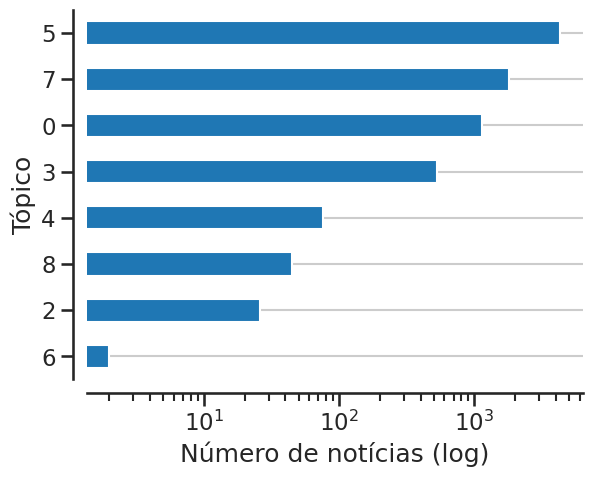

In [20]:
with sns.axes_style("ticks"):
    sns.set_context("talk")
    ax = news_2016['topic'].value_counts().sort_values().plot(kind = 'barh')
    ax.yaxis.grid(True)
    ax.set_ylabel("Tópico")
    ax.set_xlabel("Número de notícias (log)")
    sns.despine(offset = 10)
    ax.set_xscale("log")

## Crie uma nuvem de palavra para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa. 

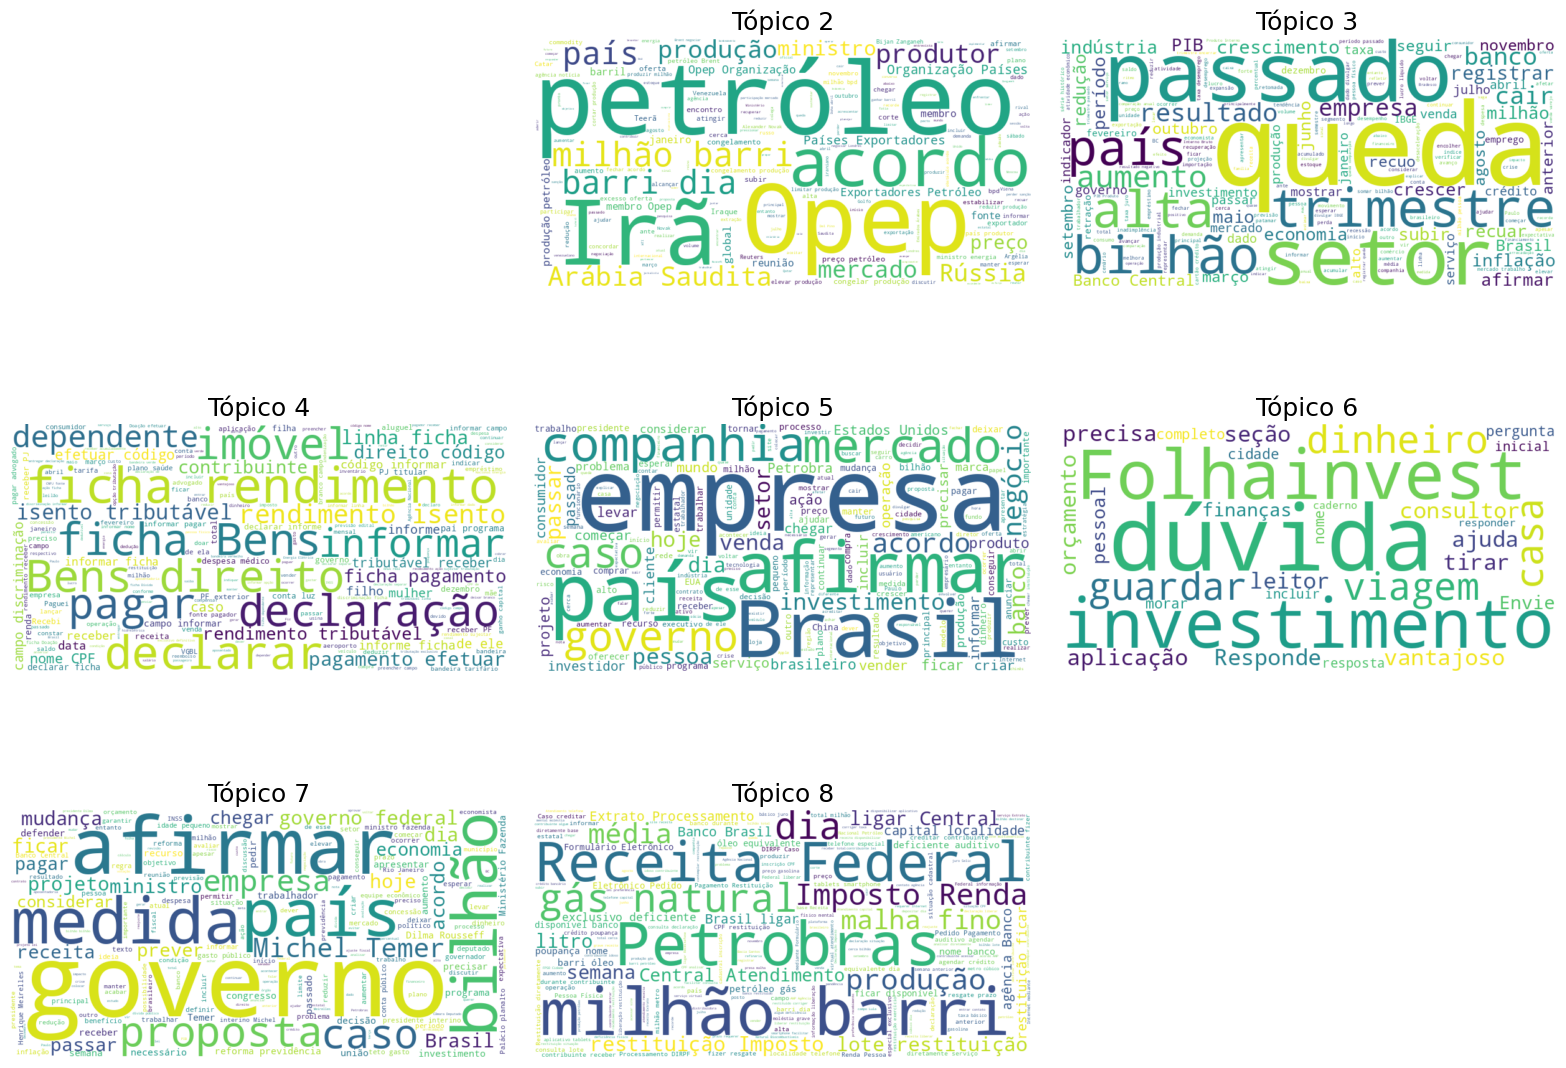

In [21]:
def plot_wordcloud(text:str, ax:plt.Axes) -> plt.Axes:
    """
    Plot a wordcloud for the given text.
    
    Arguments:
        - text: String to be analyzed.
        - ax: Matplotlib axis to plot the wordcloud.
    
    Returns:
        - ax: Modified axis with the wordcloud plot.
    """

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    
    return ax

def plot_wordcloud_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_words = chain(*topic_news.spacy_lemma.values.tolist())
    string_complete = ' '.join(list_of_words)
    if not string_complete:
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()


## Crie uma nuvem de entidades para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa. 

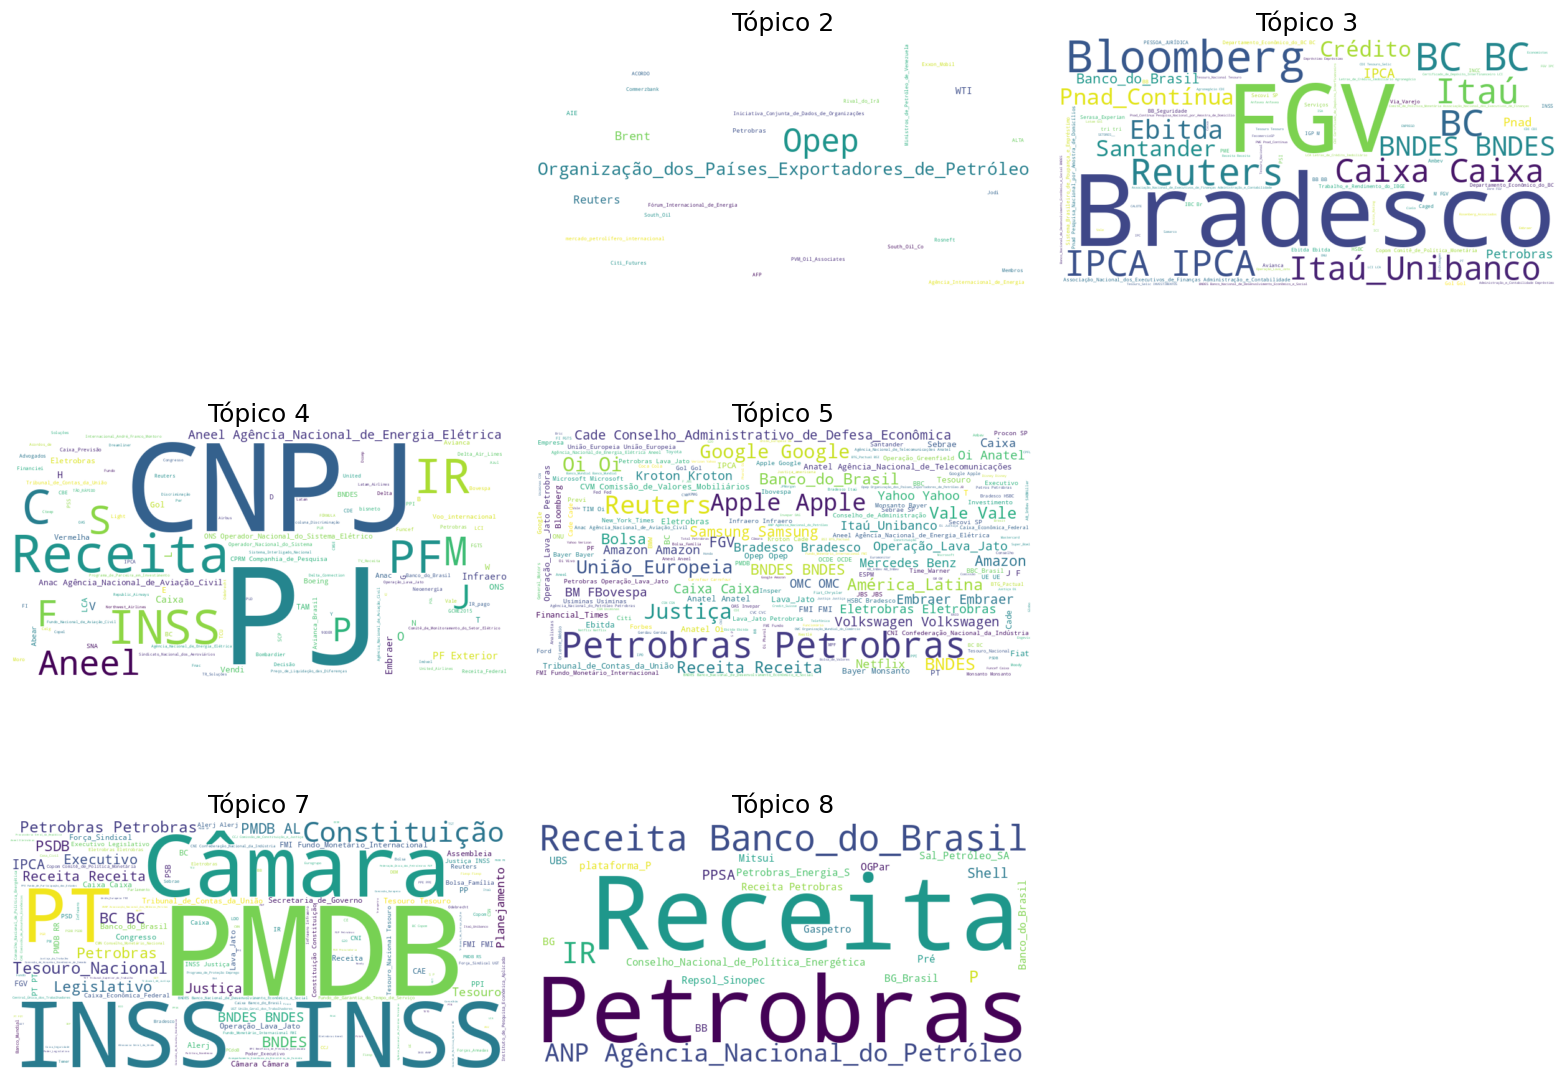

In [22]:
def plot_wordcloud_entities_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_docs = topic_news.spacy_ner.apply(lambda l : [w.replace(" ", "_") for w in l])
    list_of_words = chain(*list_of_docs)
    string_complete = ' '.join(list_of_words)
    if not len(string_complete):
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_entities_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()

### Baseado nos resultados qual a diferença entre stemming e lematização, qual a diferença entre os dois procedimentos? Escolha quatro palavras para exemplificar.

- Stemming e lematização são técnicas de normalização de texto que reduzem as palavras às suas formas básicas. No entanto, cada técnica faz isso de maneira diferente:

1. Palavra: mulher

- Stemming: mulher
- Lematização: mulher

2. Palavra: comunidade

- Stemming: comun
- Lematização: comunidade

3. Palavra: fazendeiro

- Stemming: faz
- Lematização: fazendeiro

4. Palavra: conexão

- Stemming: conex
- Lematização: conexão

### Quando adotamos uma estratégia frequentista para converter textos em vetores, podemos fazê-lo de diferentes maneiras. Mostramos em aula as codificações One-Hot, TF e TF-IDF. Explique a principal motivação em adotar TF-IDF frente as duas outras opções.

- A principal motivação em adotar TF-IDF é que essa abordagem não apenas considera a frequência de termos (TF), mas também leva em conta a frequência inversa dos documentos (IDF). Isso ajuda a reduzir o peso de termos muito comuns que aparecem em todos os documentos e destaca termos que são mais exclusivos e significativos para documentos específicos, melhorando a distinção entre diferentes textos.

### Neste projeto, usamos TF-IDF para gerar os vetores que servem de entrada para o algoritmo de LDA. Quais seriam os passos para gerar vetores baseados na técnica de Doc2Vec?

- Os passos para gerar vetores baseados na técnica de Doc2Vec seriam:

1. Preparar os documentos em formato adequado para o Doc2Vec.
2. Treinar um modelo Doc2Vec com a biblioteca Gensim, por exemplo, utilizando as classes TaggedDocument e Doc2Vec.
3. Inferir os vetores para novos documentos utilizando o modelo treinado.

### Em uma versão alternativa desse projeto, optamos por utilizar o algoritmo de K-Médias para gerar os clusters (tópicos). Qual das abordagens (TF-IDF ou Doc2Vec) seria mais adequada como processo de vetorização? Justifique com comentários sobre dimensionalidade e relação semântica entre documentos.

- A abordagem com Doc2Vec seria mais adequada para a vetorização quando se utiliza K-Médias para clustering, porque Doc2Vec captura melhor a semântica dos documentos ao representar o contexto das palavras. A dimensionalidade dos vetores de Doc2Vec pode ser ajustada para capturar a riqueza semântica necessária, ao contrário dos vetores TF-IDF que apenas consideram a frequência de termos sem relação contextual.

### O algoritmo lda2vec pretende combinar o poder do word2vec com a interpretabilidade do algoritmo LDA. Em qual cenário o autor sugere que há benefícios para utilização deste novo algoritmo?

- O autor sugere que há benefícios para a utilização do algoritmo lda2vec em cenários onde é necessário capturar a semântica dos termos em um contexto mais rico e ao mesmo tempo manter a interpretabilidade dos tópicos, especialmente em grandes coleções de texto onde a modelagem de tópicos precisa ser mais robusta e intuitiva para análise qualitativa.


### Escreva brevemente uma descrição para cada tópico extraído. Indique se você considera o tópico extraído semanticamente consistente ou não. 

1. Tópico 1 - Mercado Financeiro: Este tópico parece consistente semanticamente, pois aborda temas relacionados ao mercado financeiro, incluindo indicadores econômicos como índices de mercado, câmbio, juros e desempenho de ações. As notícias parecem coesas em torno desses temas.

2. Tópico 2 - Produção de Petróleo: Este tópico também parece consistente, abordando questões específicas relacionadas à produção de petróleo, como acordos entre países produtores, volumes de produção e decisões da Opep. As notícias dentro deste tópico compartilham uma temática comum.

3. Tópico 3 - Desempenho Econômico: Esse tópico parece consistente semanticamente, pois trata do desempenho econômico geral, incluindo aspectos como resultados trimestrais, indicadores de mercado e desempenho corporativo. As notícias estão alinhadas com essa temática.

4. Tópico 4 - Impostos e Declaração: Este tópico parece consistente, abordando questões relacionadas a impostos e declarações, como preenchimento de fichas, informes de rendimentos e prazos de declaração. As notícias dentro deste tópico compartilham uma abordagem comum sobre assuntos fiscais.

5. Tópico 5 - Empresas e Negócios: Esse tópico parece consistente, tratando de notícias relacionadas a empresas e negócios, como anúncios corporativos, resultados financeiros e desenvolvimentos empresariais. As notícias parecem estar coesas em torno dessa temática.

6. Tópico 6 - Investimentos e Finanças Pessoais: Este tópico parece consistente, abordando assuntos relacionados a investimentos e finanças pessoais, como dicas de investimento, orientações financeiras e recomendações para o público em geral. As notícias dentro deste tópico compartilham uma abordagem semelhante sobre questões financeiras.

7. Tópico 7 - Política e Governo: Esse tópico parece consistente, tratando de questões políticas e governamentais, como decisões governamentais, políticas públicas e eventos políticos relevantes. As notícias parecem estar alinhadas com essa temática política.

8. Tópico 8 - Economia Nacional: Este tópico também parece consistente, abordando questões relacionadas à economia nacional, como políticas econômicas, arrecadação de impostos e desenvolvimentos econômicos do país. As notícias dentro deste tópico compartilham uma abordagem comum sobre assuntos econômicos nacionais.


No geral, os tópicos extraídos parecem ser semanticamente consistentes, pois as notícias dentro de cada tópico compartilham uma temática comum e abordam assuntos relacionados de maneira coesa.